In [1]:
from cryo_em_sbi import CryoEmSbi
import sbi
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Configure your config file

Go to your config file and set all the parameters.

# 2. Run the script to generate images

Run `launch_gen_data.job`. The clean images and the indices will be saved automatically after the run as "images.pt" and "indices.pt". Alternatively you can edit this line in the .job file `_, __ = cryosbi.simulate($SLURM_CPUS_PER_TASK)` for something like `_, __ = cryosbi.simulate($SLURM_CPUS_PER_TASK, fname_indices=fname_for_indices.pt, fname_images=fname_for_images.pt)` if you want different names or you want to specify a path for the clean images.

# 3. Load generated images and preprocess them LOCALLY

Check again the parameters you set for preprocessing in the config file!!

In [2]:
#cryosbi_no_shift = CryoEmSbi("config_no_shift.json")
cryosbi_all = CryoEmSbi("config_all.json")
cryosbi_all_noise01 = CryoEmSbi("config_all_noise01.json")
# Edit the filename if you used something else!

#indices = torch.load("indices.pt")
#images = torch.load("images.pt")

/mnt/home/dsilvasanchez/virtual_envs/sbi_env_try/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [4]:
indices, images = cryosbi.simulate(num_workers=1)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

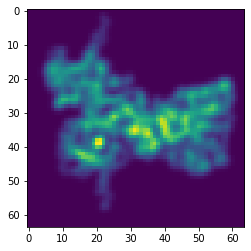

In [7]:
# Let's check how the images look for peace of mind

plt.imshow(images[2].reshape(64, 64))


# 4. Preprocessing
To properly simulate CryoEM we need to add noise, apply CTF effects, and shift the images randomly. We do not generate images directly with this effects, as it would be expensive to generate new datasets for each combination of effects. Instead we create raw images, and then apply a desired combination of filters before training.

The function below automatically saves indices and images as "indices_training.pt" and "images_training.pt".

You DON'T need to use a GPU here. I set it so the preprocessing uses the same device as the simulation. If you generated data with a CPU, you preprocess with a CPU. If you generated data with a GPU, then you do need a GPU for preprocessing.

Alternatively if you don't want to use a GPU for preprocessing, you should edit your config file to have a simulating device = "cpu" and load the indices/images in step 3 as

```
indices = torch.load("indices.pt").to("cpu")
images = torch.load("images.pt").to("cpu")
```

In [3]:
num_workers = 8
batch_size = int(images.shape[0] / num_workers)

indices_training, images_training = cryosbi.preprocess(indices, images, num_workers=num_workers, batch_size=batch_size)

del indices, images

# You can set different names for the preprocessed indices and images

# indices_training, images_training = cryosbi.preprocess(
#     indices,
#     images,
#     fname_output_indices=fname_for_indices.pt,
#     fname_output_images=fname_for_images.pt
#     )

Running 1000000 simulations in 8 batches.:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
# Again, check images for peace of mind

indices_training = torch.load("indices_training.pt")
images_training = torch.load("images_training.pt")

#plt.imshow(images_training[0].reshape(32, 32))

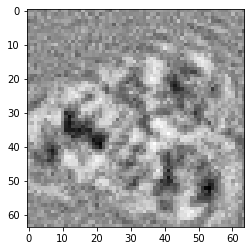

In [4]:
plt.imshow(images_training[100].reshape(64, 64),cmap="Greys_r")

# 5. Training the posterior

Since you did the preprocessing here, you don't need to do it in the .job file. PLEASE be careful when you load the indices and the images in the .job files. Be sure that you are loading the files you want to train with.

# 6. Loading posterior and checking how everything turned out

In [3]:
import torch.nn as nn 
import torch.nn.functional as F 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=8
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=6,
            kernel_size=8
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        
    def forward(self, x):
        
        x = x.view(-1, 1, 64, 64)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        return x.view(-1, 600)

In [ ]:
# embedding_net = SummaryNet()

# posterior = cryosbi.train_posterior(indices_training, images_training, num_workers=32, embedding_net=embedding_net)

# del indices_training, images_training

In [4]:
import pickle

# Be careful here! If the name of your posterior is different to the one you have in your config file, replace 
# cryosbi.config["TRAINING"]["POSTERIOR_NAME"] for "name_of_posterior_file.pkl"


#torch.loading_context(map_location='cuda')
with open("posterior_all_effects.pkl", "rb") as handle:
    posterior_all = pickle.load(handle)

# with open("posterior_no_shift.pkl", "rb") as handle:
#     posterior_no_shift = pickle.load(handle)

with open("posterior_all_effects_cnn.pkl", "rb") as handle:
    posterior_all_cnn = pickle.load(handle)

# with open("posterior_no_shift_cnn.pkl", "rb") as handle:
#     posterior_no_shift_cnn = pickle.load(handle)


with open("posterior_all_effects_noise_01_cnn.pkl", "rb") as handle:
    posterior_noisy = pickle.load(handle)

with open("posterior_all_effects_cnn_1e5images.pkl", "rb") as handle:
    posterior_few_images = pickle.load(handle)

In [ ]:
torch.save(posterior_all, "posterior_all_effects.pt")
torch.save(posterior_all_cnn, "posterior_all_effects_cnn.pt")
torch.save(posterior_noisy, "posterior_all_effects_noise_01_cnn.pt")
torch.save(posterior_few_images, "posterior_all_effects_cnn_1e5images.pt")

In [4]:
posterior_all = torch.load("posterior_all_effects.pt", map_location="cuda")
posterior_all_cnn = torch.load("posterior_all_effects_cnn.pt", map_location="cuda")
posterior_noisy = torch.load("posterior_all_effects_noise_01_cnn.pt", map_location="cuda")
posterior_few_images = torch.load("posterior_all_effects_cnn_1e5images.pt", map_location="cuda")

In [8]:
with open("posterior_cuda.pkl", "wb") as handle:
    pickle.dump(posterior, handle)


# 5. Checking if the posterior works

We can check that the posterior works by generating new images, and checking if it can pinpoint the model they were generated from.

In [5]:
cryosbi_all.quaternions = np.loadtxt("QUAT_576", skiprows=1)[0:1, :]

cryosbi_all_noise01.quaternions = np.loadtxt("QUAT_576", skiprows=1)[0:1, :]
#cryosbi_no_shift.quaternions = cryosbi_no_shift.quaternions[0:1, :]

In [6]:
torch.set_num_threads(32)

In [26]:
true_indices = torch.tensor(np.arange(0., 20., 1.).reshape(20, 1))

true_images_all = sbi.simulators.simutils.simulate_in_batches(cryosbi_all.simulator_analysis, true_indices, num_workers=1)

#true_images_no_shift = sbi.simulators.simutils.simulate_in_batches(cryosbi_no_shift.simulator_analysis, true_indices, num_workers=1)

cryosbi_all_noise01.config["PREPROCESSING"]["SNR"] = 0.5
true_images_all_noise01 = sbi.simulators.simutils.simulate_in_batches(cryosbi_all_noise01.simulator_analysis, true_indices, num_workers=1)

Running 20 simulations.:   0%|          | 0/20 [00:00<?, ?it/s]

Running 20 simulations.:   0%|          | 0/20 [00:00<?, ?it/s]

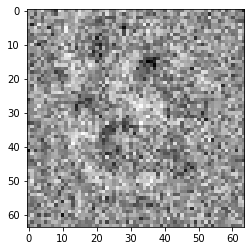

In [27]:
plt.imshow(true_images_all_noise01[4].reshape(64, 64).to("cpu"), cmap="Greys_r")

In [28]:
n_samples = 10000

samples_all = torch.zeros(20, n_samples, 1, device="cpu")
samples_all_cnn = torch.zeros(20, n_samples, 1, device="cpu")
samples_all_noisy = torch.zeros(20, n_samples, 1, device="cpu")
samples_few_images = torch.zeros(20, n_samples, 1, device="cpu")

#samples_no_shifts = torch.zeros(20, n_samples, 1, device="cpu")

#samples_no_shifts_cnn = torch.zeros(20, n_samples, 1, device="cpu")


In [29]:
for i in tqdm(range(20)):
    
    #samples_all[i] = posterior_all.sample((n_samples,), x=true_images_all[i], show_progress_bars=False)  
    #samples_all_cnn[i] = posterior_all_cnn.sample((n_samples,), x=true_images_all[i], show_progress_bars=False)  
    samples_all_noisy[i] = posterior_noisy.sample((n_samples,), x=true_images_all_noise01[i], show_progress_bars=False)  
    #samples_few_images[i] = posterior_few_images.sample((n_samples,), x=true_images_all[i], show_progress_bars=False)  
    
    #samples_no_shifts_cnn[i] = posterior_no_shift_cnn.sample((n_samples,), x=true_images_no_shift[i], show_progress_bars=False)  
    #samples_no_shifts[i] = posterior_no_shift.sample((n_samples,), x=true_images_no_shift[i], show_progress_bars=False)  

100%|██████████| 20/20 [00:00<00:00, 130.07it/s]


In [25]:
torch.save(samples_all, "samples/samples_all.pt")
torch.save(samples_no_shifts, "samples/samples_no_shift.pt")

torch.save(samples_all_cnn, "samples/samples_all_cnn.pt")
torch.save(samples_no_shifts_cnn, "samples/samples_no_shift_cnn.pt")

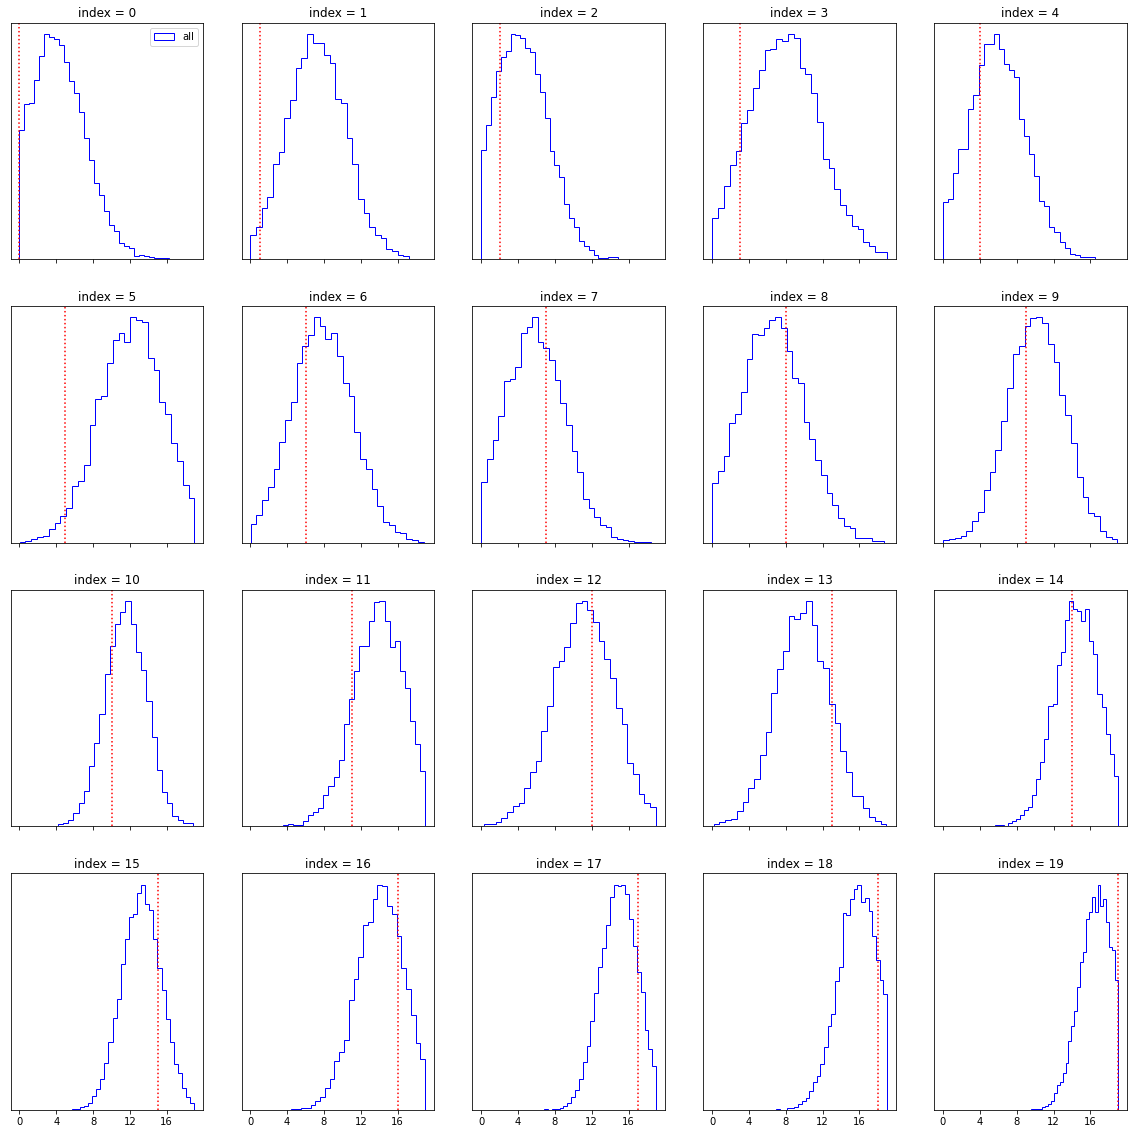

In [30]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
# fig.suptitle(f"N_IMAGES: {cryosbi.config['SIMULATION']['N_SIMULATIONS']}, SNR:{cryosbi.config['PREPROCESSING']['SNR']}, Rotations\nMAF")

for i in range(4):
    for j in range(5):

        axes[i,j].hist(samples_all_noisy[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="blue", label="all")

        #axes[i,j].hist(samples_all_cnn[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="blue", label="all")

        #axes[i,j].hist(samples_few_images[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="blue", label="all")


        #axes[i,j].hist(samples_no_shifts[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="black", label="no_shifts")


        axes[i,j].axvline(x=i*5 + j, color="red", ls=":")
        axes[i,j].set_title(f"index = {i*5 + j}")
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(range(0, 19, 4))

axes[0,0].legend()

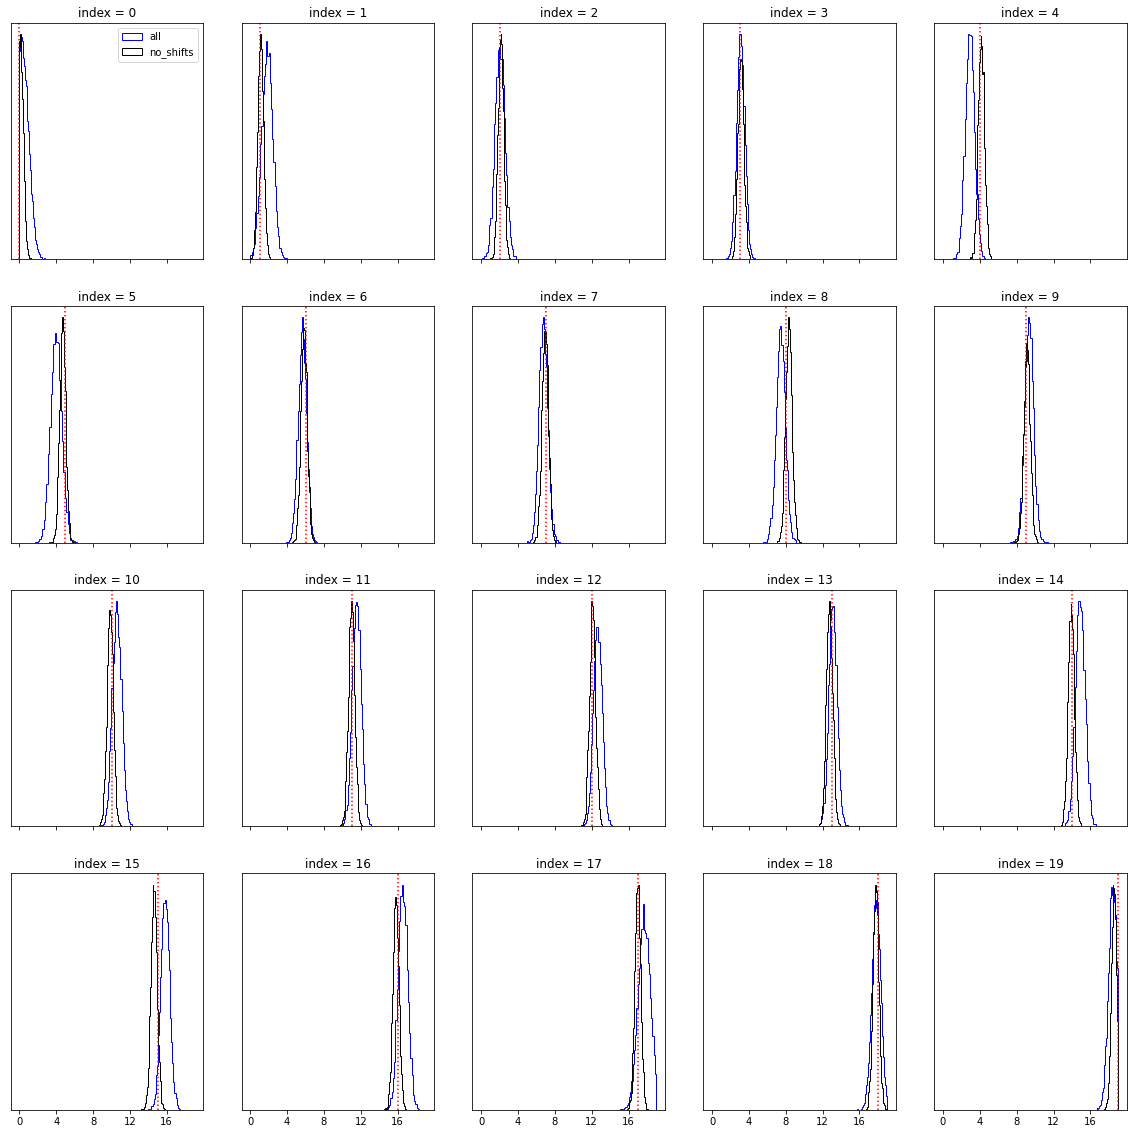

In [13]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
# fig.suptitle(f"N_IMAGES: {cryosbi.config['SIMULATION']['N_SIMULATIONS']}, SNR:{cryosbi.config['PREPROCESSING']['SNR']}, Rotations\nMAF")

for i in range(4):
    for j in range(5):

        axes[i,j].hist(samples_all_cnn[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="blue", label="all")
        axes[i,j].hist(samples_no_shifts_cnn[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="black", label="no_shifts")
        axes[i,j].axvline(x=i*5 + j, color="red", ls=":")
        axes[i,j].set_title(f"index = {i*5 + j}")
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(range(0, 19, 4))

axes[0,0].legend()

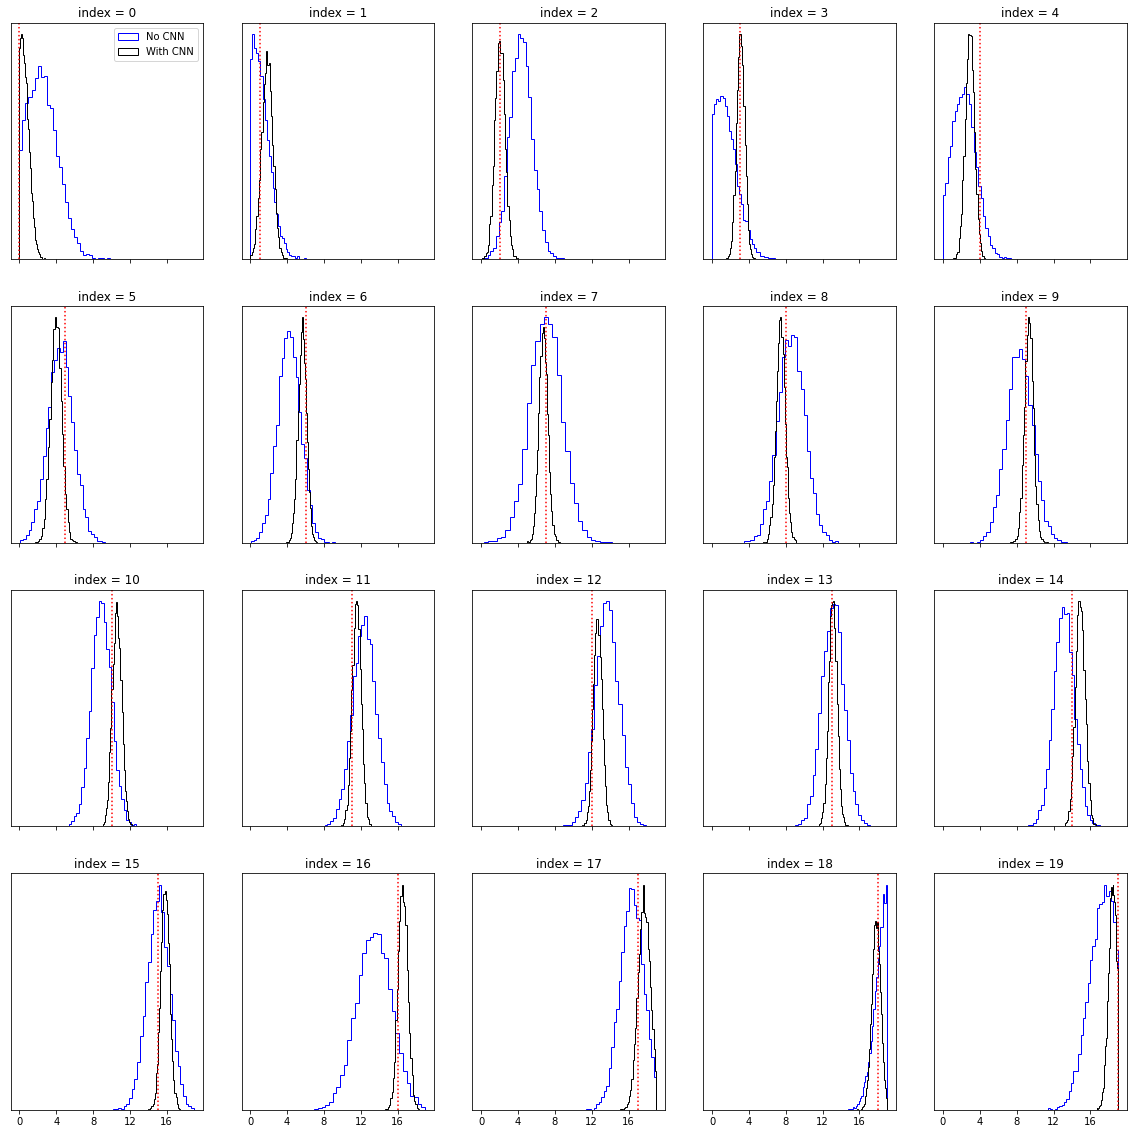

In [19]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
# fig.suptitle(f"N_IMAGES: {cryosbi.config['SIMULATION']['N_SIMULATIONS']}, SNR:{cryosbi.config['PREPROCESSING']['SNR']}, Rotations\nMAF")

for i in range(4):
    for j in range(5):

        axes[i,j].hist(samples_all[i*5 + j].numpy().flatten(), bins=30, histtype="stfig, axes = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
# fig.suptitle(f"N_IMAGES: {cryosbi.config['SIMULATION']['N_SIMULATIONS']}, SNR:{cryosbi.config['PREPROCESSING']['SNR']}, Rotations\nMAF")

for i in range(4):
    for j in range(5):

        axes[i,j].hist(samples_all_cnn[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="blue", label="all")
        axes[i,j].hist(samples_no_shifts_cnn[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="black", label="no_shifts")
        axes[i,j].axvline(x=i*5 + j, color="red", ls=":")
        axes[i,j].set_title(f"index = {i*5 + j}")
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(range(0, 19, 4))

axes[0,0].legend()ep", color="blue", label="No CNN")
        axes[i,j].hist(samples_all_cnn[i*5 + j].numpy().flatten(), bins=30, histtype="step", color="black", label="With CNN")
        axes[i,j].axvline(x=i*5 + j, color="red", ls=":")
        axes[i,j].set_title(f"index = {i*5 + j}")
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(range(0, 19, 4))

axes[0,0].legend()

In [16]:
del images_training, indices_training

# 6. Recovering Distriutions

In [80]:

# If you want to use an uniform distribution
#true_indices_fe =  cryosbi.prior_analysis.sample((20000,))

# Example for a 2-well distribution


import torch.distributions as D

mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.tensor([3., 14.]), torch.tensor([1., 1.]))
double_well_distribution = D.MixtureSameFamily(mix, comp)

true_indices_fe = double_well_distribution.sample((5000,))

# Erase non-valid elementes (<0 or >19)

true_indices_fe = true_indices_fe[true_indices_fe.round() <= 19.]
true_indices_fe = true_indices_fe[true_indices_fe.round() >= 0]

true_indices_fe = true_indices_fe.reshape(-1, 1)

In [17]:
true_indices.shape

torch.Size([5000, 1])

In [81]:
num_workers = 8
batch_size = int(true_indices.shape[0] / num_workers)

cryosbi_all_noise01.quaternions = np.loadtxt("QUAT_576", skiprows=1)

true_images_fe_all = sbi.simulators.simutils.simulate_in_batches(
    cryosbi_all_noise01.simulator_analysis,
    true_indices_fe.to("cuda"),
    num_workers=num_workers
)

# true_images_fe_no_shift = sbi.simulators.simutils.simulate_in_batches(
#     cryosbi_no_shift.simulator_analysis,
#     true_indices_fe,
#     num_workers=num_workers
# )

Running 4998 simulations in 4998 batches.:   0%|          | 0/4998 [00:00<?, ?it/s]

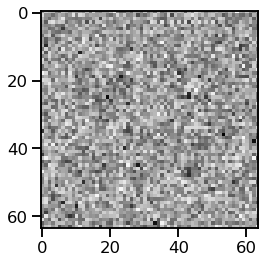

In [82]:
plt.imshow(true_images_fe_all[0].reshape(64, 64).cpu().numpy(), cmap="Greys_r")

In [83]:
n_samples = 1000

samples_all_fe = torch.zeros(true_indices_fe.shape[0], n_samples, 1, device="cpu")
samples_no_shifts_fe = torch.zeros(true_indices_fe.shape[0], n_samples, 1, device="cpu")

samples_all_fe_cnn = torch.zeros(true_indices_fe.shape[0], n_samples, 1, device="cpu")
samples_no_shifts_fe_cnn = torch.zeros(true_indices_fe.shape[0], n_samples, 1, device="cpu")

for i in tqdm(range(true_indices_fe.shape[0])):
    
    samples_all_fe[i] = posterior_all.sample((n_samples,), x=true_images_fe_all[i], show_progress_bars=False)  
    samples_no_shifts_fe[i] = posterior_no_shift.sample((n_samples,), x=true_images_fe_no_shift[i], show_progress_bars=False)  

    samples_all_fe_cnn[i] = posterior_all_cnn.sample((n_samples,), x=true_images_fe_all[i], show_progress_bars=False)  
    samples_no_shifts_fe_cnn[i] = posterior_no_shift_cnn.sample((n_samples,), x=true_images_fe_no_shift[i], show_progress_bars=False)  

  0%|          | 0/4998 [00:00<?, ?it/s]


NameError: name 'posterior_no_shift' is not defined

In [85]:
n_samples = 1000

samples_noise = torch.zeros(true_indices_fe.shape[0], n_samples, 1, device="cpu")



for i in tqdm(range(true_indices_fe.shape[0])):
    
    samples_noise[i] = posterior_noisy.sample((n_samples,), x=true_images_fe_all[i], show_progress_bars=False)  

100%|██████████| 4998/4998 [00:29<00:00, 170.78it/s]


In [24]:
torch.save(samples_all_fe, "samples/samples_all_fe.pt")
torch.save(samples_no_shifts_fe, "samples/samples_no_shift_fe.pt")

torch.save(samples_all_fe_cnn, "samples/samples_all_fe_cnn.pt")
torch.save(samples_no_shifts_fe_cnn, "samples/samples_no_shift_fe_cnn.pt")

In [88]:
samples_noise_mean = torch.mean(samples_noise, axis=1)

In [90]:
1/16

0.0625

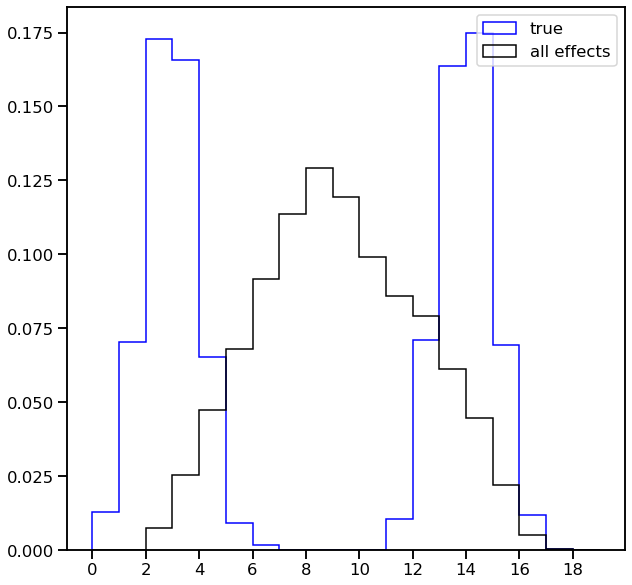

In [89]:
import seaborn as sns
sns.set_context("talk")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist(true_indices_fe.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="blue", label="true", density=True);

#ax.hist(samples_all_fe.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="black", label="all effects", density=True);

#ax.hist(samples_no_shifts_fe.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="red", label="no shifts", density=True);

ax.hist(samples_noise_mean.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="black", label="all effects", density=True);

ax.set_xticks(np.arange(0, 20, 2));
ax.set_xticks(np.arange(0, 20, 2));

ax.legend()

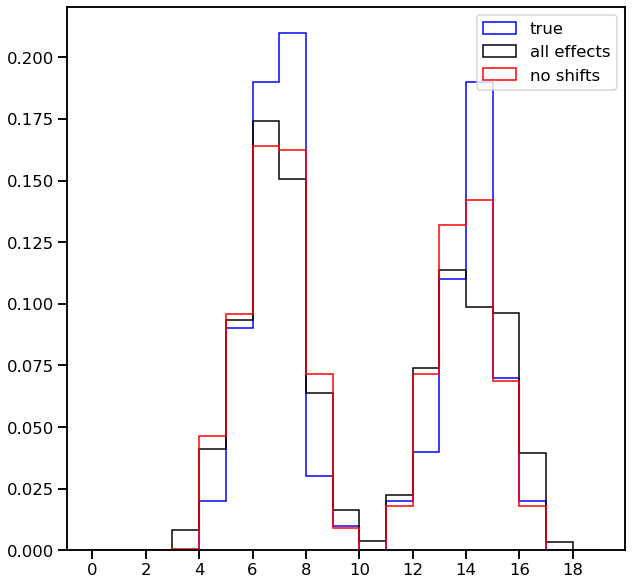

In [23]:
import seaborn as sns
sns.set_context("talk")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist(true_indices_fe.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="blue", label="true", density=True);

ax.hist(samples_all_fe_cnn.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="black", label="all effects", density=True);

ax.hist(samples_no_shifts_fe_cnn.cpu().numpy().flatten(), bins=np.arange(0, 20, 1), histtype="step", color="red", label="no shifts", density=True);


ax.set_xticks(np.arange(0, 20, 2));
ax.set_xticks(np.arange(0, 20, 2));

ax.legend()

In [22]:
meand = torch.empty(true_indices.shape[0],1)
maxd  = torch.empty(true_indices.shape[0],1)
bins = torch.arange(21)


f = open("Pwm.txt", "w")
f2 = open("true_plus.txt","w")

for i in range(true_indices.shape[0]):
    f.write(str(i))
    f2.write(str(i))
    meand[i]=torch.mean(samples[i],axis=0)
    hist,bin_ed=torch.histogram(samples[i],bins=20, range=(0., 20.))
    maxd[i]=torch.argmax(hist)
    f2.write(' '+ str(true_indices[i].numpy().flatten())+ ' '+ str(meand[i].numpy().flatten())+ ' '+ str(maxd[i].numpy().flatten()))
    for j in range(20):
         f.write(' ' + str(hist[j].numpy().flatten()))
    f.write('\n')
    f2.write('\n')

f2.close()
f.close()

print(true_indices[2],meand[2],maxd[2])

all_sam = samples.cpu().numpy().flatten()



tensor([6.1620]) tensor([5.6875]) tensor([5.])


In [28]:
histall,bin_ed=np.histogram(all_sam,bins=20, range=(0., 20.))
histmax,bin_ed=torch.histogram(meand,bins=20, range=(0., 20.))
histmean,bin_ed=torch.histogram(maxd,bins=20, range=(0., 20.))
histtrue,bin_ed=np.histogram(true_indices,bins=20, range=(0., 20.))


f3 = open("histos.txt", "w")

for j in range(20):
    f3.write(' ' + str(histtrue[j]) + ' ' + str(histall[j])+ ' ' + str(histmax[j].numpy().flatten())+' ' + str(histmean[j].numpy().flatten()))
    f3.write('\n')
    
f3.close()



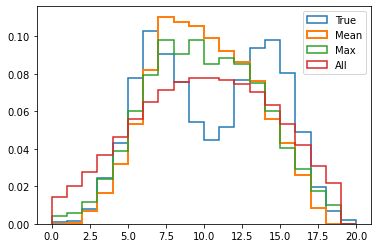

In [21]:
#plt.title(f"MODEL_FILE:{simulation_params['MODEL_FILE']}, N_IMAGES: {simulation_params['N_SIMULATIONS']}, SNR:{image_params['SNR']}, With Rotations")

plt.hist(true_indices.cpu().numpy().flatten(), bins=bins, histtype="step", linewidth=1.5,label='True', density = 'true')

plt.hist(meand.cpu().numpy().flatten(), bins=bins, histtype="step", linewidth=2.0, label = 'Mean', density = 'true')

plt.hist(maxd.cpu().numpy().flatten(), bins=bins, histtype="step", linewidth=1.5, label = 'Max', density = 'true')

plt.hist(all_sam, bins=bins, histtype="step", linewidth=1.5, label = 'All', density = 'true')
plt.legend()

plt.show()